# Estimating uncertainty in the sample mean estimator (SME)

Saleh Rezaeiravesh, salehr@kth.se <br/>
SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Stockholm, Sweden

### Introduction

Consider $n$ samples of a time series (TS), $\mathbf{f}=\{f_i\}_{i=1}^n$ which are associated to equi-spaced time samples. Using the sample-mean estimator (SME), the mean (expected value) of this TS is estimated as, 
$$
\begin{equation}\label{eq:ensembleMean}
\hat{\mu}=\hat{\mathbb{E}}[f] = \frac{1}{n}\sum_{i=1}^n f_i
\end{equation}
$$
The challenge is to accurately estimate the uncertainty in $\hat{\mu}$. An appropriate approach for this purpose has to properly deal with the fact that the samples are, in general, autocorrelated, and further, estimating the autocorrelations is not straightforward. A list of potentially appropriate approaches can be found in time series analysis books such as [Wei-2006](https://books.google.se/books/about/Time_Series_Analysis.html?id=aY0QAQAAIAAJ&source=kp_book_description&redir_esc=y) and, with regards to turbulent flows, in [Russo and Luchini 2017](https://www.sciencedirect.com/science/article/pii/S0021999117305077) and [Beyhaghi et al., 2018](https://deepai.org/publication/uncertainty-quantification-of-the-time-averaging-of-a-statistics-computed-from-numerical-simulation-of-turbulent-flow). 

The SME defined above is unbiased, meaning that $\hat{\mu} \to \mu$ as $n\to\infty$, where $\mu$ is the true but unobserved value of the expectation of $f$.
Assuming an additive error model, we get 
$$
\begin{equation}
\hat{\mu} = \mathcal{N}(\mu,\sigma^2/n) \,.
\end{equation}
$$
Our task is to estimate $\hat{\sigma}(\hat{\mu})$. 
To this end, a collection of approaches are implemented in `UQit-ts` with the highest possible generality. 
The methods can be divided into groups:
* Group 1: Estimators which do not rely on estimation of atuocorrelation functions (ACF) or autocovariance functions (ACvF). Batch-based and classical estimators, see below, are in this group.
* Group 2: Estimators which are based on an exact expression for $\sigma^2(\hat{\mu})$ which reads as,
$$
\sigma^2(\hat{\mu}) =  \frac{1}{n}\left[ {\gamma_0}+2\sum_{k=1}^{(n-1)} \left(1-\frac{k}{n}\right){\gamma_k}\right] \,.
$$
The two estimators `'DACF'` and `'ARM'` are in this category.


Currently, the following methods are available `UQit-ts`:
* `'CLSC'`: Ensemble estimator for uncorrelated samples
* `'NOBM'`: Non-overlapping Batch Mean (NOBM) method
* `'OBM'`: Overlapping Batch Mean (OBM) method
* `'BMBC'`: Batch Means and Batch Correlation (BMBC) algorithm by [Russo and Luchini 2017](https://www.sciencedirect.com/science/article/pii/S0021999117305077)
* `'DACF'`: Estimation by Direct use of sample-estimated Autocorrelation Functions (ACF)
* `'ARM'`: Estimation using modeled ACFs obtained from an Autoregressive (AR) Model Fitted to the Samples


Any of these methods may rely on some hyperparameters, for instance, the batch size in `'NOBM'`, `'OBM'`, `'BMBC'`. Given samples of a time series, choosing appropriate values for such hyperparameters in order to obtain an accurate $\hat{\sigma}(\hat{\mu})$ is non-trivial which makes the problem more challenging. 

### Example 1: Apply different batch-based methods to estimate $\hat{\sigma}^2(\hat{\mu})$
Generate $n$ samples of a synthetic TS and estimate $\hat{\sigma}(\hat{\mu})$ along with $\hat{\mu}$ using approaches such as `'CLSC'`, `'NOBM'`, `'OBM'`, and `'BMBC'` with an arbitrary batch size $N$.

Import `Python` libraries

In [1]:
import sys
import os 
import math as mt
import numpy as np
import matplotlib.pyplot as plt

Import required modules from `UQit-ts` toolbox

In [2]:
sys.path.append(os.getenv("UQit_ts_path"))
from SME import SME,SMEuncert
import stats_ts
import plot_ts
from synDataGen_ts import syntheticData

Set the settings to generate a synthetic time series

In [3]:
synOpts={'type':'synData2',
         'dt':1.0,
         'noiseSdev':0.1,
         'writeInFile':False,
         'writeFile':''}

Generate the synthetic time series of size $n$

In [4]:
n=100000;    #no of samples
t,f=syntheticData(n,synOpts).gen()

... Generating n=100000 synthetic time-series samples.
    using method synData2
    with noise sdev = 0.1


Make an SME object

In [5]:
sme_=SME(t,f,{'verbose':False,'conv':True})

Estimate $\hat{\mu}=\hat{\mathbb{E}}[f]$ and associated uncertinaty $\hat{\sigma}(\hat{\mu})$

In [6]:
M=100   #batch size
out_nobm=SMEuncert(sme_,{'method':'NOBM','batchSize':M}).estim
stdNOBM=mt.sqrt(out_nobm['fSME_var'][-1])

...... Plotting UQ estimates for the signal
...... Interpolating 999 samples to a series of 100000 samples.
       using linear method.
...... Interpolating 99999 samples to a series of 100000 samples.
       using linear method.


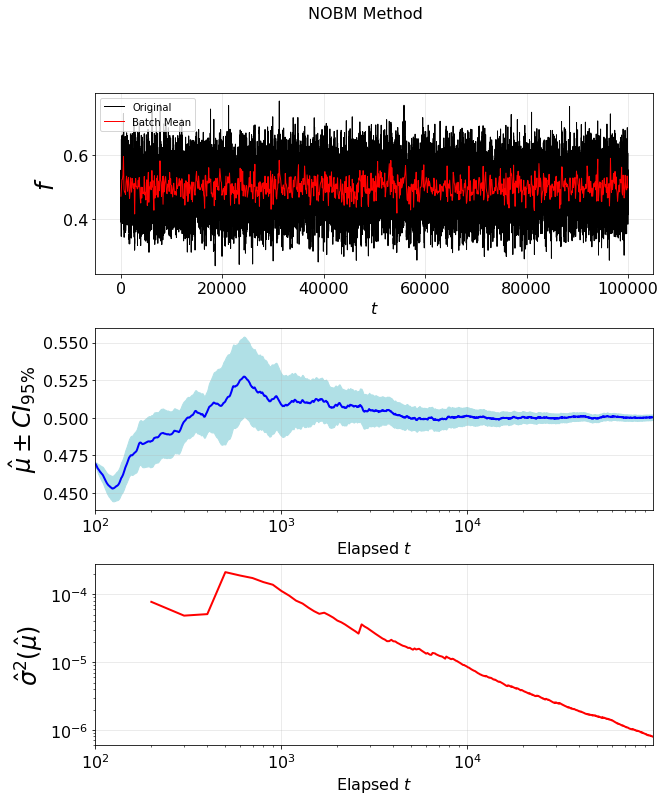

In [7]:
pltOpts={'title':'NOBM Method'}
_=plot_ts.plotter_signal_estimates(out_nobm,pltOpts)

### Example 2: Effect of the batch size on NOBM, OBM, BMBC estimations

Study the effect of the batch size on the estimated $\hat{\sigma}(\hat{\mu})$ when using different estimators. 

We use the same samples as the previous example. Note that sample size should be at least a few times larger than the batch size. 

Set the list of the batch sizes to examine.

In [8]:
batchList=[10,50,100,200,400,600,800,1000]

Estimate $\hat{\sigma}(\hat{\mu})$ for different batch sizes using `'NOBM'`, `'OBM'`, and `'BMBC'` methods.
NOTE: It may take some time, especially for `'OBM'`.

In [9]:
sig_NOBM=[]
sig_OBM=[]
sig_BMBC=[]
for M in batchList:
    out_nobm=SMEuncert(sme_,{'method':'NOBM','batchSize':M}).estim
    out_obm =SMEuncert(sme_,{'method':'OBM','batchSize':M}).estim
    out_bmbc=SMEuncert(sme_,{'method':'BMBC','batchSize':M}).estim    
    sig_NOBM.append(out_nobm['fSME_var'][-1])
    sig_OBM.append(out_obm['fSME_var'][-1])
    sig_BMBC.append(out_bmbc['fSME_var'][-1])
sig_NOBM=np.asarray(sig_NOBM)
sig_OBM =np.asarray(sig_OBM)
sig_BMBC=np.asarray(sig_BMBC)

Plot the results

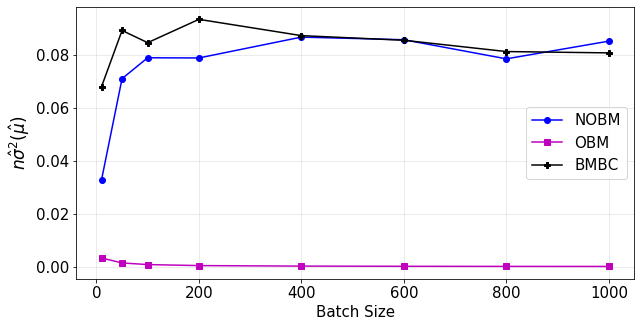

In [10]:
plt.figure(figsize=(10,5))
plt.plot(batchList,sig_NOBM*n,'-ob',label='NOBM')
plt.plot(batchList,sig_OBM*n,'-sm',label='OBM')
plt.plot(batchList,sig_BMBC*n,'-Pk',label='BMBC')
plt.xlabel('Batch Size',fontsize=15)
plt.ylabel(r'$n\hat{\sigma}^2(\hat{\mu})$',fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.grid(alpha=0.3)

Conclusion: The batch size can introduce a bias in the estimated uncertainties.

### Example 3: Estimation of $\hat{\sigma}^2(\hat{\mu})$ using `'DACF'` and `'ARM'`

As mentioned above, there is an exact expression for $\sigma^2(\hat{\mu})$. 
* In `'DACF'`, the ACvFs $\gamma_k$ are replaced by their associated sample- estimated $\hat{\gamma}_k$.
* In `'ARM'`, first an AR model is fitted to the samples, then a power-law model is used for $\gamma_k$. The details can be found in [notebook04](https://gitr.sys.kth.se/salehr/UQit_ts/blob/master/main_tUQ/examples/ex04_ts/ex04.ipynb). 

Let's apply `'DACF'` and `'ARM'` to the same set of samples as in the previous examples.

To investigate the variation of the estimated sample mean and associated uncertainty, we divide the $n$ samples into `nChunk` chunks. The size of chunks are $\{M,2M,...,nChunk M\}$ where $M=n/nChunk$. 

...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Computing autocorrelations (ACF)
...... Plotting UQ estimates for the signal
...... Interpolating 20 samples to a series of 100000 samples.
       using linear method.
...... Interpolating 99999 samples to a series of 100000 samples.

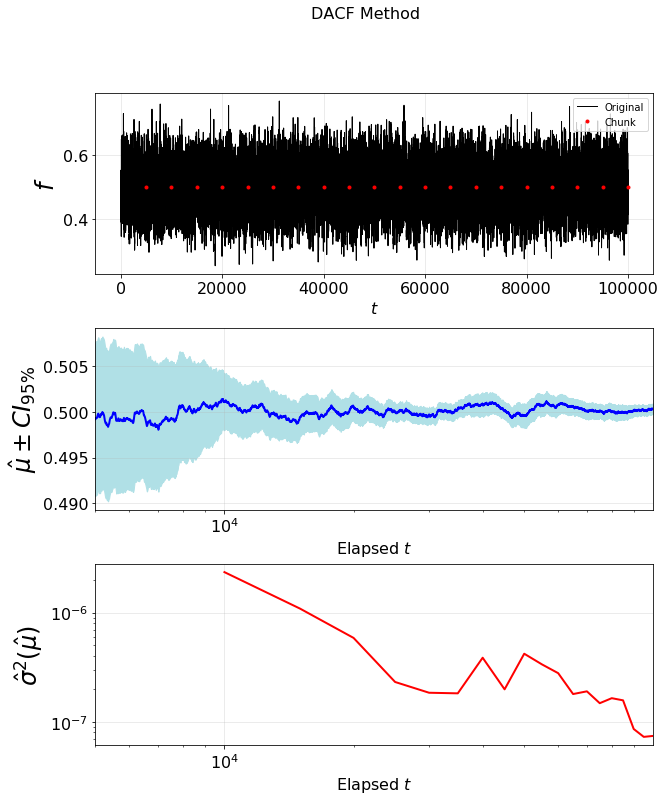

In [11]:
out_dacf=SMEuncert(sme_,{'method':'DACF','nChunk':20}).estim
pltOpts={'title':'DACF Method'}
_=plot_ts.plotter_signal_estimates(out_dacf,pltOpts)

Now we try `'ARM'`. To to that first we need to set options `opts`.

In [12]:
arm_opts={'method':'ARM',       #Method of estimating uncertainty in SME
          'AR-method':'burg',   #Method to fit AR to the samples
          'maxlag':10,          #Order of the AR model
          'nLagTrain':20,      #Number of samples when fitting a power-law to the ACF's using AR(p)
          'nChunk':20           #Number of chunks to plot the convergence of estimators
         }

out_arm=SMEuncert(sme_,arm_opts).estim

    Estimated optimal lag p=10 using method mle
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelations (ACF)
    Assigned optimal lag p= 10
...... Computing autocorrelat

...... Plotting UQ estimates for the signal
...... Interpolating 20 samples to a series of 100000 samples.
       using linear method.
...... Interpolating 99999 samples to a series of 100000 samples.
       using linear method.


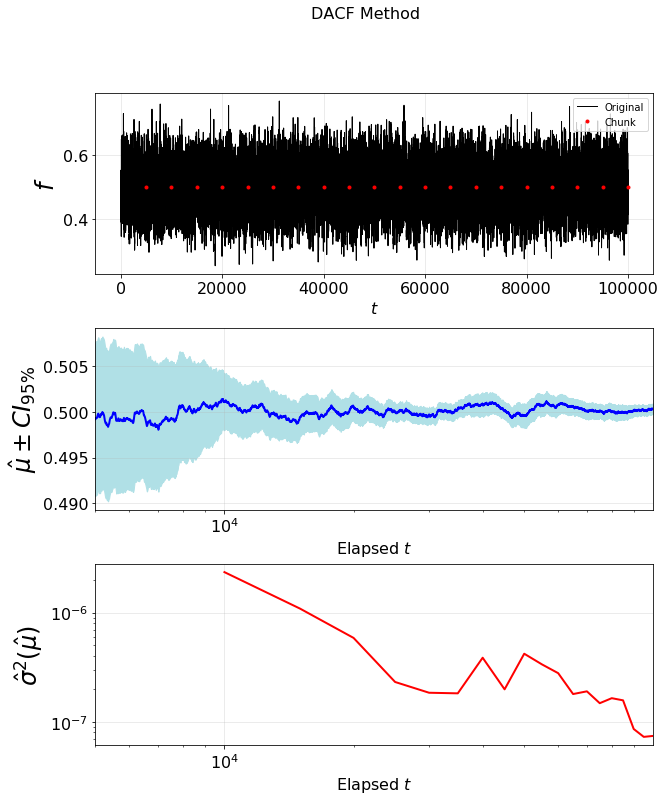

In [13]:
_=plot_ts.plotter_signal_estimates(out_dacf,pltOpts)

Now, we can compare the estimated $n\hat{\sigma}^2(\hat{\mu})$ using different methods and considering all samples $n$.

In [14]:
print('NOBM: ',n*out_nobm['fSME_var'][-1])
print(' OBM: ',n*out_obm['fSME_var'][-1])
print('BMBC:',n*out_bmbc['fSME_var'][-1])
print('DACF:',n*out_dacf['fSME_var'][-1])
print(' ARM:',n*out_arm['fSME_var'][-1])

NOBM:  0.08525255164727699
 OBM:  9.02922387605284e-05
BMBC: 0.08081254502536947
DACF: 0.0074344889069976
 ARM: 0.08847775672693428
